## Fine-tune Stable DiffusionXL with DreamBooth and LoRA.

#### Step 1: Install libraries and dependencies.

In [1]:
!pip install bitsandbytes transformers accelerate peft -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.8/119.8 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 40.6 MB/s eta 0:00:00


Get the diffusers repository from HuggingFace.

In [2]:
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


Download diffusers SDXL DreamBooth training script.

In [3]:
!wget https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py

--2024-06-10 08:17:25--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 84311 (82K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  82.33K  --.-KB/s    in 0.01s   

2024-06-10 08:17:25 (6.53 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [84311/84311]



#### Step 2: Training data

Create a folder named `SDXL_train` and upload all your training images in it. Make sure all the images are either `.png` or `.jpg`

In [4]:
import os
from google.colab import files

!gdown "1yNTncZHm5wWBTaT6d3o7-AZw2SwBHUIy"
import zipfile
with zipfile.ZipFile("/content/just_images.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/")
os.rename("/content/just_images", "/content/SDXL_train")
# local_dir = "./SDXL_train/"
# os.makedirs(local_dir)
# os.chdir(local_dir)

# # Browse the images from your computer and upload it into the SDXL_train directory.
# uploaded_images = files.upload()
# os.chdir("/content")

Downloading...
From (original): https://drive.google.com/uc?id=1yNTncZHm5wWBTaT6d3o7-AZw2SwBHUIy
From (redirected): https://drive.google.com/uc?id=1yNTncZHm5wWBTaT6d3o7-AZw2SwBHUIy&confirm=t&uuid=a46db234-a374-43f1-b542-d3dae9e996fd
To: /content/just_images.zip
100% 29.0M/29.0M [00:00<00:00, 33.7MB/s]


Preview the images.

In [5]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

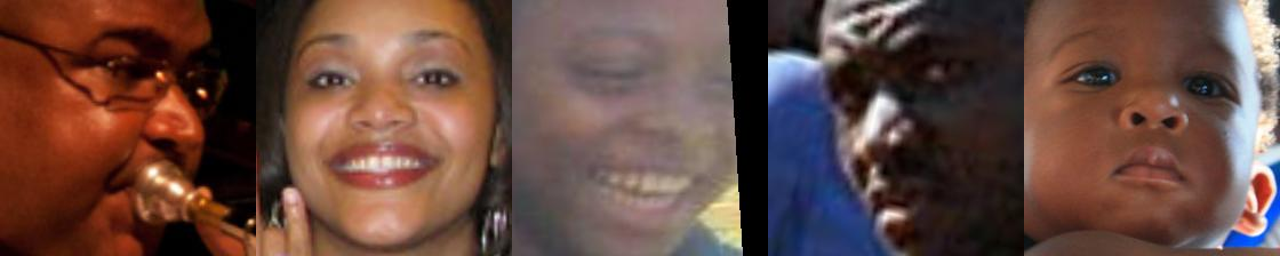

In [6]:
import glob

# change path to display images from your local dir
img_paths = "./SDXL_train/*.jpg"
imgs = [Image.open(path) for path in glob.glob(img_paths)]

num_imgs_to_preview = 5
image_grid(imgs[:num_imgs_to_preview], 1, num_imgs_to_preview)

**Generate custom captions with BLIP**

Load BLIP to auto caption your images.

In [7]:
import requests
from transformers import AutoProcessor, BlipForConditionalGeneration
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

# load the processor and the captioning model
blip_processor = AutoProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base",torch_dtype=torch.float16).to(device)

# captioning utility
def caption_images(input_image):
    inputs = blip_processor(images=input_image, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values

    generated_ids = blip_model.generate(pixel_values=pixel_values, max_length=50)
    generated_caption = blip_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_caption

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [8]:
import glob
from PIL import Image

# create a list of (Pil.Image, path) pairs
local_dir = "./SDXL_train/"
imgs_and_paths = [(path,Image.open(path)) for path in glob.glob(f"{local_dir}*.jpg")]

#### Add a token identifier

Let's incorporate a token identifier (e.g., TOK) into each caption by introducing a caption prefix.

Feel free to customize the prefix based on the specific concept you are training on.

For example: If you're fine-tuning on -
*   Human face - "Photo of a TOK person"
*   Car - "A photo of a TOK car"
*   Styles - "In the style of watercolour"



In [ ]:
import json

caption_prefix = "a black person, "
with open(f'{local_dir}metadata.jsonl', 'w') as outfile:
  for img in imgs_and_paths:
      caption = caption_prefix + caption_images(img[1]).split("\n")[0]
      entry = {"file_name":img[0].split("/")[-1], "prompt": caption}
      json.dump(entry, outfile)
      outfile.write('\n')

Free up some memory.

In [ ]:
import gc

# Delete the BLIP pipelines and free up some memory.
del blip_processor, blip_model
gc.collect()
torch.cuda.empty_cache()

#### Step 3: Start training

Initialize `accelerate`:

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

!accelerate config default

#### Setting the hyperparameters
To ensure seamless integration of DreamBooth with LoRA on a resource-intensive pipeline like Stable Diffusion XL, we are implementing the following techniques:

* Gradient checkpointing (`--gradient_accumulation_steps`)
* 8-bit Adam (`--use_8bit_adam`)
* Mixed-precision training (`--mixed-precision="fp16"`)

For custom captions, the installation of the `datasets` library is required. However, if you intend to train exclusively with `--instance_prompt`, you have the option to skip this step. In such instances, please specify `--instance_data_dir` instead of `--dataset_name`.

In [ ]:
!pip install datasets -q

 - Specify your LoRA model repository name using `--output_dir`.
 - Use `--caption_column` to indicate the name of the caption column in your dataset.

 In this example, "prompt" was used to save captions in the metadata file; feel free to modify this based on your requirements.

In [ ]:
#!/usr/bin/env bash
!accelerate launch train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --dataset_name="SDXL_train" \
  --output_dir="SDXL_LoRA_model" \
  --caption_column="prompt"\
  --mixed_precision="fp16" \
  --instance_prompt="a black person" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=3 \
  --gradient_checkpointing \
  --learning_rate=1e-4 \
  --snr_gamma=5.0 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --max_train_steps=500 \
  --checkpointing_steps=717 \
  --seed="0"

#### Step 4: Inference model
Load the fine-tuned LoRA weights.

In [ ]:
import torch
from diffusers import DiffusionPipeline, AutoencoderKL

vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipe = DiffusionPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    vae=vae,
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe.load_lora_weights('/content/SDXL_LoRA_model/pytorch_lora_weights.safetensors')
_ = pipe.to("cuda")

Text to Image Generation

In [ ]:
prompt = "A black person, playing hockey"

image = pipe(prompt=prompt, num_inference_steps=25).images[0]

# Save the SDXL image output.
image.save('/content/sdxl_output.png')

#### Image to Image Generation

Load the fine-tuned LoRA weights.

In [ ]:
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import make_image_grid, load_image

pipeline = AutoPipelineForImage2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipeline.load_lora_weights('/content/SDXL_LoRA_model/pytorch_lora_weights.safetensors')
_ = pipeline.to("cuda")

pipeline.enable_model_cpu_offload()

**Note:** Image-to-image generation might possibly require a runtime restart.

In [ ]:
# Pass the text-to-image generated output as an input to image-to-image.
image2image = load_image('/content/sdxl_output.png')
resized_image = image2image.resize((1024, 576))

prompt = "A black person, playing hockey."

# pass prompt and image to pipeline
image_output = pipeline(prompt, image=resized_image, strength=0.5).images[0]
make_image_grid([image, image_output], rows=1, cols=2)

#### Stable Video Diffusion (Image to Video)

Now, we pass the output of SDXL as an input to SVD to generate a video of the created image.

In [ ]:
!pip install -q -U diffusers transformers accelerate

In [ ]:
import torch

from diffusers import StableVideoDiffusionPipeline
from diffusers.utils import load_image, export_to_video

pipe = StableVideoDiffusionPipeline.from_pretrained(
    "stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16"
)

# pipe.enable_model_cpu_offload()
# pipe.to("cuda")

pipe.enable_model_cpu_offload()
pipe.unet.enable_forward_chunking()


# Load the conditioning image.
image = load_image("/content/sdxl_output.png")
resized_image = image.resize((1024, 576))

generator = torch.manual_seed(42)
# frames = pipe(image, decode_chunk_size=8, generator=generator).frames[0]
frames = pipe(resized_image, decode_chunk_size=2, generator=generator, num_frames=25).frames[0]

export_to_video(frames, "generated.mp4", fps=7)

#### SVD with micro-conditioning

In [ ]:
pipe = StableVideoDiffusionPipeline.from_pretrained(
  "stabilityai/stable-video-diffusion-img2vid-xt", torch_dtype=torch.float16, variant="fp16"
)
pipe.enable_model_cpu_offload()

# Load the conditioning image.
image1 = load_image("/content/sdxl_output.png")
image1 = image1.resize((1024, 576))

generator = torch.manual_seed(42)
frames = pipe(image1, decode_chunk_size=8, generator=generator, motion_bucket_id=180, noise_aug_strength=0.1).frames[0]
export_to_video(frames, "generated_micro_conditioning.mp4", fps=7)

#### Step 5: Model Deployment on HF *Spaces*

The fine-tuned SDXL model with LoRA weights can be deployed on HuggingFace Hub and hosted as an application on HF Spaces.

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Login to your HuggingFace account, go to your profile settings --> Access Tokens --> copy the access token and paste in the box below.

In [ ]:
from huggingface_hub import whoami
from pathlib import Path

# Output directory.
output_dir = "SDXL_LoRA_model"
username = whoami(token=Path("/root/.cache/huggingface/"))["name"]
repo_id = f"{username}/{output_dir}"

In [ ]:
from train_dreambooth_lora_sdxl import save_model_card
from huggingface_hub import upload_folder, create_repo

repo_id = create_repo(repo_id, exist_ok=True).repo_id

# change the params below according to your training arguments
save_model_card(
    repo_id = repo_id,
    images=[],
    base_model="stabilityai/stable-diffusion-xl-base-1.0",
    train_text_encoder=False,
    instance_prompt="a photo of TOK home",
    validation_prompt=None,
    repo_folder=output_dir,
    vae_path="madebyollin/sdxl-vae-fp16-fix",
)

upload_folder(
    repo_id=repo_id,
    folder_path=output_dir,
    commit_message="End of training",
    ignore_patterns=["step_*", "epoch_*"],
)

#### Step 6: On-device deployment using MediaPipe Image Generator Task
(under development)

#### Get the foundation model

In [ ]:
# Import HuggingFace Hub.
from huggingface_hub import hf_hub_download

# Download the v1-5-pruned-emaonly foundation diffusion model checkpoint.
hf_hub_download(repo_id="runwayml/stable-diffusion-v1-5", filename="v1-5-pruned-emaonly.ckpt", local_dir="/content/")

In [ ]:
# Install the necessary libraries.
!pip install torch typing_extensions numpy Pillow requests pytorch_lightning absl-py

#### Convert the diffusion model checkpoint to MediaPipe Image Generator format.

In [ ]:
# Get the Python script to convert the diffusion checkpoints to a format suitable for on-device deployment.
!wget https://raw.githubusercontent.com/NSTiwari/Stable-DiffusionXL-using-DreamBooth-and-LoRA-on-Android/main/convert_diffusion_checkpoints.py

# Create a directory for model.
os.makedirs('./model')

# Convert the foundation diffusion model checkpoints to the Image Generator format.
!python3 convert_diffusion_checkpoints.py --ckpt_path /content/v1-5-pruned-emaonly.ckpt --output_path /content/model/

In [ ]:
# Download the converted foundation model.
!zip -r /content/model.zip /content/model/

In [ ]:
files.download('/content/model.zip')